In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold,StratifiedKFold
import sys

In [3]:
def readData(filename):
    df=pd.read_csv(filename,header=None,delimiter=' ')
    return df

class LogLinearModel:
    def __init__(self,args):
        np.random.seed(0)
        self.args=args
        self.params={}
        self.params['w']=np.random.randn(self.args['dim']) / np.sqrt(self.args['dim'])
        self.params['w']=np.append(self.params['w'],0.0)
    
    def loss_bp(self,X,y=np.array([])):
        N,D=X.shape
        
        # Y is none, test only
        if y.size==0:
            score=np.zeros(N)
            for i,xi in enumerate(X):
                linear=np.matmul(self.params['w'],xi)
                exp_linear=np.exp(linear)
                prob_y1=exp_linear/(1+exp_linear)
                score[i]=prob_y1
#             print("This score: ",score)
            return score
        
        loss=0.0
        grad=np.zeros(D)
        
        for xi,yi in zip(X,y):
            term1=np.log(1+np.exp(np.dot(self.params['w'],xi)))
            term2=yi*np.dot(self.params['w'],xi)
            loss_xi=term1-term2
            loss+=loss_xi
            
            linear=np.matmul(self.params['w'],xi)
            exp_linear=np.exp(linear)
            prob_y1=exp_linear/(1+exp_linear)
            
            grad_xi=-np.dot(xi,(yi-prob_y1))
            grad+=grad_xi
        
        return loss,grad
        
    def predict(self,X):
        return (self.loss_bp(X)>0.5).astype(int)

    def train(self,train_df,val_df):
        
        y=train_df.iloc[:,-1].values
        X=train_df.iloc[:,:-1].values
        X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
        Xhat=np.c_[X,np.ones(X.shape[0])]
        
        y_val=val_df.iloc[:,-1].values
        X_val=val_df.iloc[:,:-1].values
        X_val=(X_val-np.mean(X_val,axis=0))/np.std(X_val,axis=0)
        Xhat_val=np.c_[X_val,np.ones(X_val.shape[0])]
     
        loss_history=[]
        train_acc_history=[]
        val_acc_history=[]
           
        N,D=Xhat.shape
        iter_times=int(N*self.args['epoch']/self.args['batch_size'])

        # Label y must start with 0
        for it in range(iter_times):

            start=it*self.args['batch_size']%N
            end=start+self.args['batch_size']
            X_batch=Xhat[start:end,:]
            y_batch=y[start:end]
            
            loss,grad=self.loss_bp(X_batch,y_batch)
            loss_history.append(loss)

            self.params['w'] += -grad*self.args['learning_rate']
            
            train_acc=(self.predict(Xhat)==y).mean()
            train_acc_history.append(train_acc)

            val_acc=(self.predict(Xhat_val)==y_val).mean()
            val_acc_history.append(val_acc)
            
            if it*self.args['batch_size']%N==0:
                self.args['learning_rate']*=self.args['learning_rate_decay']
                
            if self.args['debug']==True and it*self.args['batch_size']%N==0:
                print("it: ",it," N ",N, "Epoch: ",it*self.args['batch_size']//N," Train Accuracy: ",train_acc,
                       " Val Accuracy: ",val_acc)
                for scorei,yi in zip(self.loss_bp(Xhat)[-10:],y[-10:]):
                    print(" [%.2f|%d] " % (scorei,yi),end='')
                print("\n")
                    

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history':val_acc_history,
            }


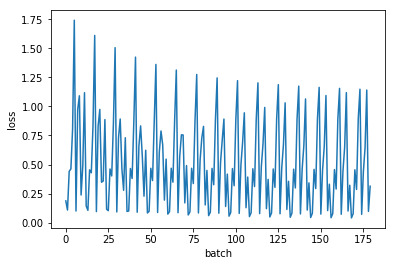

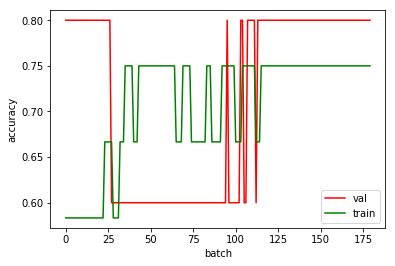

[ 0.59869733  1.47970572 -0.01289536]
Final Val Acc:  0.8
Final Train Acc:  0.75


In [4]:
if __name__=='__main__':
    df=readData('watermelon.csv')
    args={
        'dim':2,
        'batch_size':1,
        'epoch':15,
        'learning_rate':1e-1,
        'learning_rate_decay':0.95,
        'debug':False,
    }
    temp=args
    logLinearModel=LogLinearModel(args)
    history=logLinearModel.train(df.iloc[list(range(0,6))+list(range(11,17)),:],df.iloc[6:11,:])
    plt.plot(np.arange(len(history['loss_history'])),history['loss_history'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    plt.savefig('linear_log_loss.png',dpi=500)
    plt.show()
    plt.plot(np.arange(len(history['val_acc_history'])),history['val_acc_history'],color='r',label='val')
    plt.plot(np.arange(len(history['train_acc_history'])),history['train_acc_history'],color='g',label='train')
    plt.xlabel('batch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.savefig('linear_log_acc.png',dpi=500)
    plt.show()
    print(logLinearModel.params['w'])
    print("Final Val Acc: ",history['val_acc_history'][-1])
    print("Final Train Acc: ",history['train_acc_history'][-1])

In [218]:
if __name__=='__main__':
    epoch=[5,10,15,20,25,30]
    lr=[1e-1,5e-2,1e-2,5e-3,1e-3]
    size=[1,2,3,4,5,6]
    gmax=0.0
    great=None
    for sizei in size:
        for ei in epoch:
            for lri in lr:
                df=readData('watermelon.csv')
                args={
                    'dim':2,
                    'batch_size':sizei,
                    'epoch':ei,
                    'learning_rate':lri,
                    'learning_rate_decay':0.95,
                    'detail':False,
                }
                temp=args
                logLinearModel=LogLinearModel(args)
                history=logLinearModel.train(df.iloc[list(range(0,6))+list(range(11,17)),:],df.iloc[6:11,:])
    #             plt.plot(np.arange(len(history['loss_history'])),history['loss_history'])
    #             plt.show()
    #             plt.scatter(np.arange(len(history['train_acc_history'])),history['train_acc_history'])
    #             plt.show()
                if history['val_acc_history'][-1]>gmax:
                    gmax=history['val_acc_history'][-1]
                    print("Total Acc: ",history['val_acc_history'][-1])
                    great=temp
                    great['acc']=history['val_acc_history'][-1]
    print(great)

Total Acc:  0.6
Total Acc:  0.8
{'dim': 2, 'batch_size': 1, 'epoch': 5, 'learning_rate': 0.007737809374999999, 'learning_rate_decay': 0.95, 'detail': False, 'acc': 0.8}


In [50]:
def readIris(filename):
    df=pd.read_csv(filename,delimiter=',')
    df1=df[df['species'].isin(['setosa','versicolor'])].copy()
    df2=df[df['species'].isin(['setosa','virginica'])].copy()
    df1['species'] = pd.Categorical(df1['species'])
    df2['species'] = pd.Categorical(df1['species'])
    df1['code'] = df1.species.cat.codes
    df2['code']=df2.species.cat.codes
    df1 = df1.drop('species', axis=1)
    df2 = df2.drop('species',axis=1)
#     print(df1)
    return df1,df2



In [73]:
if __name__=='__main__':
    datasets=list(readIris('iris.csv'))
    args={
        'dim':4,
        'batch_size':1,
        'epoch':15,
        'learning_rate':1e-1,
        'learning_rate_decay':0.95,
        'debug':False,
    }
    datasetNames=['Iris-(setosa,versicolor)','Iris- (setosa,virginica)']
    
    print("Ten fold cross val:")
    for idx,dataset in enumerate(datasets):
        
        # Ten fold cross val
        sfolder = StratifiedKFold(n_splits=10,random_state=0)
        sfolder.get_n_splits(dataset)
        acc_history=[]
        for train_index, test_index in sfolder.split(dataset,dataset.iloc[:,-1].values):
            dataset_train, dataset_test = dataset.iloc[train_index], dataset.iloc[test_index]
            logLinearModel=LogLinearModel(args)
            history=logLinearModel.train(dataset_train,dataset_test)
            acc_history.append(history['val_acc_history'][-1])
        print(datasetNames[idx]," Acc history: ",acc_history," Mean Accuracy: ",np.mean(acc_history))

Ten fold cross val:
Iris-(setosa,versicolor)  Acc history:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  Mean Accuracy:  1.0
Iris- (setosa,virginica)  Acc history:  [1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  Mean Accuracy:  0.99


In [72]:
datasets=list(readIris('iris.csv'))
args={
    'dim':4,
    'batch_size':1,
    'epoch':15,
    'learning_rate':1e-1,
    'learning_rate_decay':0.95,
    'debug':False,
}
datasetNames=['Iris-(setosa,versicolor)','Iris- (setosa,virginica)']
print("Leave one cross val:")
for idx,dataset in enumerate(datasets):
    dataset=dataset.reset_index()
    # Leave one cross val
    acc_history=[]
    for i in range(dataset.shape[0]):
        bad_df = dataset.index.isin([i])
        dataset_train, dataset_test = dataset[~bad_df], dataset[bad_df]
        logLinearModel=LogLinearModel(args)
        history=logLinearModel.train(dataset_train,dataset_test)
        acc_history.append(history['val_acc_history'][-1])
#     print(acc_history)
#     print(sum(acc_history) / len(acc_history) )
    print(datasetNames[idx]," Mean Accuracy: ",np.mean(acc_history))

Leave one cross val:
Iris-(setosa,versicolor)  Mean Accuracy:  1.0
Iris- (setosa,virginica)  Mean Accuracy:  0.99


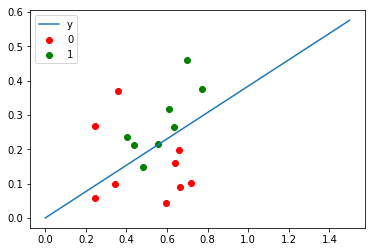

In [87]:
def LDA(c1,c2):
        m1=np.mean(c1,axis=0)
        m2=np.mean(c2,axis=0)
        c=np.vstack((c1,c2))
        m=np.mean(c,axis=0)
        n1=c1.shape[0]
        n2=c2.shape[0]
        s1=0
        s2=0
        for i in range(n1):
            s1+=(c1[i,:]-m1).T*(c1[i,:]-m1)
        for i in range(n2):
            s2+= (c2[i, :] - m2).T * (c2[i, :] - m2)
        sw=(n1*s1+n2*s2)/(n1+n2)
        sb=((n1*(m-m1).T*(m-m1))+(n2*(m-m2)).T*(m-m2))/(n1+n2)
        a,b=np.linalg.eig(np.mat(sw).I*sb)
        index=np.argsort(-a)
        maxIndex=index[:1]
        w=b[:,maxIndex]
        return w

if __name__=='__main__':
    df=readData('watermelon.csv')
    y0=df[df[2]==0].iloc[:,-1]
    y1=df[df[2]==1].iloc[:,-1]
    X0=df[df[2]==0].iloc[:,:-1].values
    X1=df[df[2]==1].iloc[:,:-1].values
    
    omiga=LDA(X0,X1)
    plt.scatter(X0[:,0],X0[:,1],label='0',color='red')
    plt.scatter(X1[:,0],X1[:,1],label='1',color='green')
    k=omiga[1,0]/omiga[0,0]
    plt.plot([0,1.5],[0,1.5*k],label='y')
    plt.legend()
    plt.show()

In [113]:
df=pd.read_csv('iris.csv',delimiter=',')
print(df.columns[:-1])
cont=['>2','<=2']
for c in cont:
    print(df.loc[df['sepal_length']])

SyntaxError: invalid syntax (<ipython-input-113-f4c806a3aff9>, line 5)